<a href="https://colab.research.google.com/github/Ankitatiwary21/-PersonaGen/blob/main/UNET%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets


In [2]:
import opendatasets as od
import os

od.download("https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ankitatiwary21
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation


100%|██████████| 312M/312M [00:00<00:00, 714MB/s]


In [3]:
# Verify download
dataset_path = "/content/brain-tumor-segmentation"
print("Downloaded contents:", os.listdir(dataset_path))

Downloaded contents: ['images', 'masks']


In [4]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Packages imported and seeds set!")

✅ Packages imported and seeds set!


In [5]:
# Configuration
IMG_SIZE = 128  # Reduced size for faster training
BATCH_SIZE = 8
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE

# Paths
images_path = "/content/brain-tumor-segmentation/images"
masks_path = "/content/brain-tumor-segmentation/masks"

# Get all images and masks
all_images = sorted(os.listdir(images_path))
all_masks = sorted(os.listdir(masks_path))

# Ensure mask filenames match image filenames
all_masks = [img.replace(".jpg", ".png").replace(".jpeg", ".png") for img in all_images]

# Shuffle the data
random.seed(42)
combined = list(zip(all_images, all_masks))
random.shuffle(combined)
all_images, all_masks = zip(*combined)

# 85-15 split
split_idx = int(0.85 * len(all_images))
train_images = all_images[:split_idx]
test_images = all_images[split_idx:]
train_masks = all_masks[:split_idx]
test_masks = all_masks[split_idx:]

print(f"Train: {len(train_images)} | Test: {len(test_images)}")

Train: 2604 | Test: 460


In [6]:
# U-Net++ MODEL IMPLEMENTATION
def build_unet_plus_plus(input_shape=(128, 128, 3)):
    """
    Builds U-Net++ model with dense skip connections for improved gradient flow
    and better feature propagation.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder Path
    # Level 0
    x00 = layers.Conv2D(64, 3, padding='same')(inputs)
    x00 = layers.BatchNormalization()(x00)
    x00 = layers.Activation('relu')(x00)
    x00 = layers.Conv2D(64, 3, padding='same')(x00)
    x00 = layers.BatchNormalization()(x00)
    x00 = layers.Activation('relu')(x00)
    p0 = layers.MaxPooling2D()(x00)

    # Level 1
    x10 = layers.Conv2D(128, 3, padding='same')(p0)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    x10 = layers.Conv2D(128, 3, padding='same')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    p1 = layers.MaxPooling2D()(x10)

    # Level 2
    x20 = layers.Conv2D(256, 3, padding='same')(p1)
    x20 = layers.BatchNormalization()(x20)
    x20 = layers.Activation('relu')(x20)
    x20 = layers.Conv2D(256, 3, padding='same')(x20)
    x20 = layers.BatchNormalization()(x20)
    x20 = layers.Activation('relu')(x20)
    p2 = layers.MaxPooling2D()(x20)

    # Level 3
    x30 = layers.Conv2D(512, 3, padding='same')(p2)
    x30 = layers.BatchNormalization()(x30)
    x30 = layers.Activation('relu')(x30)
    x30 = layers.Conv2D(512, 3, padding='same')(x30)
    x30 = layers.BatchNormalization()(x30)
    x30 = layers.Activation('relu')(x30)
    p3 = layers.MaxPooling2D()(x30)

    # Bridge (Level 4)
    x40 = layers.Conv2D(1024, 3, padding='same')(p3)
    x40 = layers.BatchNormalization()(x40)
    x40 = layers.Activation('relu')(x40)
    x40 = layers.Conv2D(1024, 3, padding='same')(x40)
    x40 = layers.BatchNormalization()(x40)
    x40 = layers.Activation('relu')(x40)

    # Decoder Path with Dense Skip Connections (U-Net++ Architecture)

    # Level 3 Decoder
    # x31: Upsample from bridge and connect with x30
    up_x31 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(x40)
    x31 = layers.concatenate([up_x31, x30])
    x31 = layers.Conv2D(512, 3, padding='same')(x31)
    x31 = layers.BatchNormalization()(x31)
    x31 = layers.Activation('relu')(x31)
    x31 = layers.Conv2D(512, 3, padding='same')(x31)
    x31 = layers.BatchNormalization()(x31)
    x31 = layers.Activation('relu')(x31)

    # Level 2 Decoder
    # x21: Upsample from x31 and connect with x20
    up_x21 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x31)
    x21 = layers.concatenate([up_x21, x20])
    x21 = layers.Conv2D(256, 3, padding='same')(x21)
    x21 = layers.BatchNormalization()(x21)
    x21 = layers.Activation('relu')(x21)
    x21 = layers.Conv2D(256, 3, padding='same')(x21)
    x21 = layers.BatchNormalization()(x21)
    x21 = layers.Activation('relu')(x21)

    # x22: Upsample from bridge and connect with x20 and x21 (dense connection)
    up_x22_1 = layers.Conv2DTranspose(256, 4, strides=4, padding='same')(x40)
    up_x22_2 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x31)
    x22 = layers.concatenate([up_x22_1, up_x22_2, x20, x21])
    x22 = layers.Conv2D(256, 3, padding='same')(x22)
    x22 = layers.BatchNormalization()(x22)
    x22 = layers.Activation('relu')(x22)
    x22 = layers.Conv2D(256, 3, padding='same')(x22)
    x22 = layers.BatchNormalization()(x22)
    x22 = layers.Activation('relu')(x22)

    # Level 1 Decoder
    # x11: Upsample from x22 and connect with x10
    up_x11 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x22)
    x11 = layers.concatenate([up_x11, x10])
    x11 = layers.Conv2D(128, 3, padding='same')(x11)
    x11 = layers.BatchNormalization()(x11)
    x11 = layers.Activation('relu')(x11)
    x11 = layers.Conv2D(128, 3, padding='same')(x11)
    x11 = layers.BatchNormalization()(x11)
    x11 = layers.Activation('relu')(x11)

    # x12: Upsample from x31 and connect with x10 and x11
    up_x12_1 = layers.Conv2DTranspose(128, 4, strides=4, padding='same')(x31)
    up_x12_2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x22)
    x12 = layers.concatenate([up_x12_1, up_x12_2, x10, x11])
    x12 = layers.Conv2D(128, 3, padding='same')(x12)
    x12 = layers.BatchNormalization()(x12)
    x12 = layers.Activation('relu')(x12)
    x12 = layers.Conv2D(128, 3, padding='same')(x12)
    x12 = layers.BatchNormalization()(x12)
    x12 = layers.Activation('relu')(x12)

    # x13: Upsample from bridge and connect with all previous
    up_x13_1 = layers.Conv2DTranspose(128, 8, strides=8, padding='same')(x40)
    up_x13_2 = layers.Conv2DTranspose(128, 4, strides=4, padding='same')(x31)
    up_x13_3 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x22)
    x13 = layers.concatenate([up_x13_1, up_x13_2, up_x13_3, x10, x11, x12])
    x13 = layers.Conv2D(128, 3, padding='same')(x13)
    x13 = layers.BatchNormalization()(x13)
    x13 = layers.Activation('relu')(x13)
    x13 = layers.Conv2D(128, 3, padding='same')(x13)
    x13 = layers.BatchNormalization()(x13)
    x13 = layers.Activation('relu')(x13)

    # Level 0 Decoder (Final)
    # x01: Upsample from x13 and connect with x00
    up_x01 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x13)
    x01 = layers.concatenate([up_x01, x00])
    x01 = layers.Conv2D(64, 3, padding='same')(x01)
    x01 = layers.BatchNormalization()(x01)
    x01 = layers.Activation('relu')(x01)
    x01 = layers.Conv2D(64, 3, padding='same')(x01)
    x01 = layers.BatchNormalization()(x01)
    x01 = layers.Activation('relu')(x01)

    # OUTPUT LAYER
    outputs = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32')(x01)

    model = Model(inputs, outputs, name='UNet_Plus_Plus')
    return model

print("✅ U-Net++ model defined!")

✅ U-Net++ model defined!


In [7]:
# LOSS FUNCTIONS AND METRICS (SAME AS BEFORE)
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice coefficient metric - measures overlap between prediction and ground truth
    Perfect segmentation = 1, No overlap = 0
    """
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    """
    Combined loss: Binary Cross Entropy + Dice Loss
    BCE ensures pixel-wise accuracy, Dice ensures region overlap
    """
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice_loss = 1 - dice_coef(y_true, y_pred)
    return bce + dice_loss

print("✅ Loss functions and metrics defined!")

✅ Loss functions and metrics defined!


In [8]:
# DATA PIPELINE (SAME AS BEFORE)
def load_and_preprocess_image(img_path, mask_path):
    """
    Load and preprocess image and mask pair
    """
    # Read images
    img = tf.io.read_file(img_path)
    mask = tf.io.read_file(mask_path)

    # Decode images
    img = tf.image.decode_png(img, channels=3)
    mask = tf.image.decode_png(mask, channels=1)

    # Resize to model input size
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])

    # Normalize images to [0,1] and ensure binary masks
    img = tf.cast(img, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.cast(mask > 0.5, tf.float32)  # Binarize mask

    return img, mask

def create_dataset(image_files, mask_files, training=True):
    """
    Create TensorFlow dataset from file lists
    """
    # Create full paths
    img_paths = [os.path.join(images_path, f) for f in image_files]
    mask_paths = [os.path.join(masks_path, f) for f in mask_files]

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    if training:
        dataset = dataset.shuffle(buffer_size=100)

    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("✅ Data pipeline created!")

✅ Data pipeline created!


In [9]:
# TRAINING WITH K-FOLD CROSS VALIDATION (SAME STRUCTURE, DIFFERENT MODEL)
FOLDS = 2  # Reduced for faster training, increase to 5 for better results
histories = []

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
fold_no = 1

for train_idx, val_idx in kf.split(train_images):
    print(f"\n🎯 === Fold {fold_no}/{FOLDS} ===")

    # Get fold data
    fold_train_images = [train_images[i] for i in train_idx]
    fold_train_masks  = [train_masks[i] for i in train_idx]
    fold_val_images   = [train_images[i] for i in val_idx]
    fold_val_masks    = [train_masks[i] for i in val_idx]

    # Create datasets
    train_ds = create_dataset(fold_train_images, fold_train_masks, training=True)
    val_ds   = create_dataset(fold_val_images, fold_val_masks, training=False)

    # Build and compile U-Net++ model
    model = build_unet_plus_plus(input_shape=(IMG_SIZE, IMG_SIZE, 3))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=bce_dice_loss,
        metrics=[dice_coef, 'accuracy']
    )

    print(f"✅ U-Net++ model compiled for fold {fold_no}")

    # Callbacks
    ckpt_path = f"/content/unet_plus_plus_fold{fold_no}.h5"
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            ckpt_path,
            monitor='val_dice_coef',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_dice_coef',
            factor=0.5,
            patience=4,
            mode='max',
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_dice_coef',
            mode='max',
            patience=8,
            verbose=1,
            restore_best_weights=True
        )
    ]

    # Train model
    print(f"🚀 Training fold {fold_no}...")
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1
    )

    histories.append(history)
    fold_no += 1

print("✅ Training complete for all folds!")


🎯 === Fold 1/2 ===
✅ U-Net++ model compiled for fold 1
🚀 Training fold 1...
Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.9202 - dice_coef: 0.0777 - loss: 1.2398
Epoch 1: val_dice_coef improved from -inf to 0.02240, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 176s 712ms/step - accuracy: 0.9205 - dice_coef: 0.0780 - loss: 1.2388 - val_accuracy: 0.9817 - val_dice_coef: 0.0224 - val_loss: 1.2512 - learning_rate: 1.0000e-04
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9808 - dice_coef: 0.2326 - loss: 0.8661
Epoch 2: val_dice_coef improved from 0.02240 to 0.04112, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 435ms/step - accuracy: 0.9808 - dice_coef: 0.2327 - loss: 0.8659 - val_accuracy: 0.9449 - val_dice_coef: 0.0411 - val_loss: 1.1569 - learning_rate: 1.0000e-04
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9842 - dice_coef: 0.3271 - loss: 0.7470
Epoch 3: val_dice_coef improved from 0.04112 to 0.23944, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.9842 - dice_coef: 0.3272 - loss: 0.7468 - val_accuracy: 0.9554 - val_dice_coef: 0.2394 - val_loss: 0.9124 - learning_rate: 1.0000e-04
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9870 - dice_coef: 0.4152 - loss: 0.6429
Epoch 4: val_dice_coef improved from 0.23944 to 0.41559, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 416ms/step - accuracy: 0.9870 - dice_coef: 0.4153 - loss: 0.6428 - val_accuracy: 0.9867 - val_dice_coef: 0.4156 - val_loss: 0.6453 - learning_rate: 1.0000e-04
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9890 - dice_coef: 0.5018 - loss: 0.5453
Epoch 5: val_dice_coef improved from 0.41559 to 0.54085, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 430ms/step - accuracy: 0.9890 - dice_coef: 0.5019 - loss: 0.5451 - val_accuracy: 0.9881 - val_dice_coef: 0.5408 - val_loss: 0.5161 - learning_rate: 1.0000e-04
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9905 - dice_coef: 0.5830 - loss: 0.4577
Epoch 6: val_dice_coef did not improve from 0.54085
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 349ms/step - accuracy: 0.9905 - dice_coef: 0.5830 - loss: 0.4577 - val_accuracy: 0.9837 - val_dice_coef: 0.5231 - val_loss: 0.5432 - learning_rate: 1.0000e-04
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9920 - dice_coef: 0.6506 - loss: 0.3837
Epoch 7: val_dice_coef improved from 0.54085 to 0.61362, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 493ms/step - accuracy: 0.9920 - dice_coef: 0.6506 - loss: 0.3836 - val_accuracy: 0.9891 - val_dice_coef: 0.6136 - val_loss: 0.4331 - learning_rate: 1.0000e-04
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9931 - dice_coef: 0.7041 - loss: 0.3252
Epoch 8: val_dice_coef improved from 0.61362 to 0.66599, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 437ms/step - accuracy: 0.9931 - dice_coef: 0.7041 - loss: 0.3252 - val_accuracy: 0.9912 - val_dice_coef: 0.6660 - val_loss: 0.3726 - learning_rate: 1.0000e-04
Epoch 9/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9936 - dice_coef: 0.7449 - loss: 0.2826
Epoch 9: val_dice_coef did not improve from 0.66599
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 349ms/step - accuracy: 0.9936 - dice_coef: 0.7449 - loss: 0.2826 - val_accuracy: 0.9918 - val_dice_coef: 0.6575 - val_loss: 0.3820 - learning_rate: 1.0000e-04
Epoch 10/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9941 - dice_coef: 0.7666 - loss: 0.2588
Epoch 10: val_dice_coef improved from 0.66599 to 0.68983, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 437ms/step - accuracy: 0.9941 - dice_coef: 0.7666 - loss: 0.2588 - val_accuracy: 0.9915 - val_dice_coef: 0.6898 - val_loss: 0.3502 - learning_rate: 1.0000e-04
Epoch 11/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9945 - dice_coef: 0.7916 - loss: 0.2328
Epoch 11: val_dice_coef improved from 0.68983 to 0.70273, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 405ms/step - accuracy: 0.9945 - dice_coef: 0.7916 - loss: 0.2328 - val_accuracy: 0.9922 - val_dice_coef: 0.7027 - val_loss: 0.3362 - learning_rate: 1.0000e-04
Epoch 12/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9949 - dice_coef: 0.8106 - loss: 0.2117
Epoch 12: val_dice_coef did not improve from 0.70273
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 349ms/step - accuracy: 0.9949 - dice_coef: 0.8106 - loss: 0.2117 - val_accuracy: 0.9907 - val_dice_coef: 0.6184 - val_loss: 0.4340 - learning_rate: 1.0000e-04
Epoch 13/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9951 - dice_coef: 0.8205 - loss: 0.2013
Epoch 13: val_dice_coef improved from 0.70273 to 0.71077, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 433ms/step - accuracy: 0.9951 - dice_coef: 0.8205 - loss: 0.2013 - val_accuracy: 0.9922 - val_dice_coef: 0.7108 - val_loss: 0.3268 - learning_rate: 1.0000e-04
Epoch 14/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9955 - dice_coef: 0.8361 - loss: 0.1844
Epoch 14: val_dice_coef improved from 0.71077 to 0.73588, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 439ms/step - accuracy: 0.9955 - dice_coef: 0.8361 - loss: 0.1843 - val_accuracy: 0.9927 - val_dice_coef: 0.7359 - val_loss: 0.3014 - learning_rate: 1.0000e-04
Epoch 15/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9957 - dice_coef: 0.8504 - loss: 0.1688
Epoch 15: val_dice_coef did not improve from 0.73588
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 349ms/step - accuracy: 0.9957 - dice_coef: 0.8504 - loss: 0.1688 - val_accuracy: 0.9918 - val_dice_coef: 0.6720 - val_loss: 0.3754 - learning_rate: 1.0000e-04
Epoch 16/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9956 - dice_coef: 0.8457 - loss: 0.1745
Epoch 16: val_dice_coef improved from 0.73588 to 0.75062, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 499ms/step - accuracy: 0.9956 - dice_coef: 0.8457 - loss: 0.1745 - val_accuracy: 0.9927 - val_dice_coef: 0.7506 - val_loss: 0.2877 - learning_rate: 1.0000e-04
Epoch 17/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9959 - dice_coef: 0.8595 - loss: 0.1593
Epoch 17: val_dice_coef did not improve from 0.75062
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 350ms/step - accuracy: 0.9959 - dice_coef: 0.8596 - loss: 0.1593 - val_accuracy: 0.9928 - val_dice_coef: 0.7394 - val_loss: 0.2976 - learning_rate: 1.0000e-04
Epoch 18/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9960 - dice_coef: 0.8616 - loss: 0.1570
Epoch 18: val_dice_coef did not improve from 0.75062
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 346ms/step - accuracy: 0.9960 - dice_coef: 0.8617 - loss: 0.1570 - val_accuracy: 0.9923 - val_dice_coef: 0.7094 - val_loss: 0.3342 - learning_rate: 1.0000e-04
Epoch 19/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9961 - dice_coef: 0.8674 - loss

163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 432ms/step - accuracy: 0.9961 - dice_coef: 0.8674 - loss: 0.1505 - val_accuracy: 0.9928 - val_dice_coef: 0.7526 - val_loss: 0.2851 - learning_rate: 1.0000e-04
Epoch 20/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9966 - dice_coef: 0.8834 - loss: 0.1323
Epoch 20: val_dice_coef did not improve from 0.75263
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 350ms/step - accuracy: 0.9966 - dice_coef: 0.8834 - loss: 0.1323 - val_accuracy: 0.9930 - val_dice_coef: 0.7481 - val_loss: 0.2918 - learning_rate: 1.0000e-04
Epoch 21/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9969 - dice_coef: 0.8954 - loss: 0.1189
Epoch 21: val_dice_coef improved from 0.75263 to 0.75883, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 530ms/step - accuracy: 0.9969 - dice_coef: 0.8954 - loss: 0.1189 - val_accuracy: 0.9931 - val_dice_coef: 0.7588 - val_loss: 0.2779 - learning_rate: 1.0000e-04
Epoch 22/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9969 - dice_coef: 0.8948 - loss: 0.1192
Epoch 22: val_dice_coef improved from 0.75883 to 0.76496, saving model to /content/unet_plus_plus_fold1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 475ms/step - accuracy: 0.9969 - dice_coef: 0.8948 - loss: 0.1192 - val_accuracy: 0.9934 - val_dice_coef: 0.7650 - val_loss: 0.2729 - learning_rate: 1.0000e-04
Epoch 23/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9973 - dice_coef: 0.9088 - loss: 0.1035
Epoch 23: val_dice_coef did not improve from 0.76496
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 350ms/step - accuracy: 0.9973 - dice_coef: 0.9088 - loss: 0.1035 - val_accuracy: 0.9930 - val_dice_coef: 0.7528 - val_loss: 0.2890 - learning_rate: 1.0000e-04
Epoch 24/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9971 - dice_coef: 0.9030 - loss: 0.1103
Epoch 24: val_dice_coef did not improve from 0.76496
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 345ms/step - accuracy: 0.9971 - dice_coef: 0.9031 - loss: 0.1102 - val_accuracy: 0.9930 - val_dice_coef: 0.7512 - val_loss: 0.2902 - learning_rate: 1.0000e-04
Epoch 25/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9974 - dice_coef: 0.9117 - loss

163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 405ms/step - accuracy: 0.9974 - dice_coef: 0.9117 - loss: 0.1001 - val_accuracy: 0.9932 - val_dice_coef: 0.7680 - val_loss: 0.2721 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 25.

🎯 === Fold 2/2 ===
✅ U-Net++ model compiled for fold 2
🚀 Training fold 2...
Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8829 - dice_coef: 0.0733 - loss: 1.2836
Epoch 1: val_dice_coef improved from -inf to 0.02320, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 533ms/step - accuracy: 0.8833 - dice_coef: 0.0736 - loss: 1.2825 - val_accuracy: 0.9531 - val_dice_coef: 0.0232 - val_loss: 1.3159 - learning_rate: 1.0000e-04
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9792 - dice_coef: 0.2191 - loss: 0.8867
Epoch 2: val_dice_coef improved from 0.02320 to 0.02425, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 638ms/step - accuracy: 0.9792 - dice_coef: 0.2191 - loss: 0.8866 - val_accuracy: 0.9447 - val_dice_coef: 0.0242 - val_loss: 1.1871 - learning_rate: 1.0000e-04
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9841 - dice_coef: 0.3015 - loss: 0.7763
Epoch 3: val_dice_coef improved from 0.02425 to 0.12493, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 619ms/step - accuracy: 0.9841 - dice_coef: 0.3016 - loss: 0.7761 - val_accuracy: 0.9792 - val_dice_coef: 0.1249 - val_loss: 0.9701 - learning_rate: 1.0000e-04
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9864 - dice_coef: 0.3883 - loss: 0.6736
Epoch 4: val_dice_coef improved from 0.12493 to 0.39758, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 425ms/step - accuracy: 0.9864 - dice_coef: 0.3884 - loss: 0.6735 - val_accuracy: 0.9824 - val_dice_coef: 0.3976 - val_loss: 0.6748 - learning_rate: 1.0000e-04
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9893 - dice_coef: 0.4783 - loss: 0.5693
Epoch 5: val_dice_coef improved from 0.39758 to 0.47495, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 472ms/step - accuracy: 0.9893 - dice_coef: 0.4784 - loss: 0.5692 - val_accuracy: 0.9887 - val_dice_coef: 0.4750 - val_loss: 0.5753 - learning_rate: 1.0000e-04
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9902 - dice_coef: 0.5439 - loss: 0.4982
Epoch 6: val_dice_coef improved from 0.47495 to 0.53395, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 464ms/step - accuracy: 0.9902 - dice_coef: 0.5439 - loss: 0.4981 - val_accuracy: 0.9876 - val_dice_coef: 0.5339 - val_loss: 0.5158 - learning_rate: 1.0000e-04
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9924 - dice_coef: 0.6308 - loss: 0.4021
Epoch 7: val_dice_coef improved from 0.53395 to 0.56093, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 458ms/step - accuracy: 0.9924 - dice_coef: 0.6309 - loss: 0.4020 - val_accuracy: 0.9906 - val_dice_coef: 0.5609 - val_loss: 0.4798 - learning_rate: 1.0000e-04
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9927 - dice_coef: 0.6743 - loss: 0.3566
Epoch 8: val_dice_coef improved from 0.56093 to 0.62309, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 648ms/step - accuracy: 0.9927 - dice_coef: 0.6744 - loss: 0.3565 - val_accuracy: 0.9916 - val_dice_coef: 0.6231 - val_loss: 0.4144 - learning_rate: 1.0000e-04
Epoch 9/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9940 - dice_coef: 0.7269 - loss: 0.2990
Epoch 9: val_dice_coef improved from 0.62309 to 0.66201, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 483ms/step - accuracy: 0.9940 - dice_coef: 0.7269 - loss: 0.2990 - val_accuracy: 0.9914 - val_dice_coef: 0.6620 - val_loss: 0.3768 - learning_rate: 1.0000e-04
Epoch 10/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9945 - dice_coef: 0.7646 - loss: 0.2590
Epoch 10: val_dice_coef improved from 0.66201 to 0.66410, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 505ms/step - accuracy: 0.9945 - dice_coef: 0.7646 - loss: 0.2590 - val_accuracy: 0.9920 - val_dice_coef: 0.6641 - val_loss: 0.3732 - learning_rate: 1.0000e-04
Epoch 11/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9953 - dice_coef: 0.8021 - loss: 0.2180
Epoch 11: val_dice_coef improved from 0.66410 to 0.70092, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 503ms/step - accuracy: 0.9953 - dice_coef: 0.8021 - loss: 0.2181 - val_accuracy: 0.9923 - val_dice_coef: 0.7009 - val_loss: 0.3366 - learning_rate: 1.0000e-04
Epoch 12/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9955 - dice_coef: 0.8165 - loss: 0.2030
Epoch 12: val_dice_coef did not improve from 0.70092
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 350ms/step - accuracy: 0.9955 - dice_coef: 0.8165 - loss: 0.2031 - val_accuracy: 0.9911 - val_dice_coef: 0.6917 - val_loss: 0.3500 - learning_rate: 1.0000e-04
Epoch 13/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9952 - dice_coef: 0.8159 - loss: 0.2046
Epoch 13: val_dice_coef improved from 0.70092 to 0.72074, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 429ms/step - accuracy: 0.9952 - dice_coef: 0.8160 - loss: 0.2046 - val_accuracy: 0.9926 - val_dice_coef: 0.7207 - val_loss: 0.3161 - learning_rate: 1.0000e-04
Epoch 14/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9958 - dice_coef: 0.8389 - loss: 0.1793
Epoch 14: val_dice_coef improved from 0.72074 to 0.73010, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 464ms/step - accuracy: 0.9958 - dice_coef: 0.8389 - loss: 0.1793 - val_accuracy: 0.9922 - val_dice_coef: 0.7301 - val_loss: 0.3087 - learning_rate: 1.0000e-04
Epoch 15/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9959 - dice_coef: 0.8502 - loss: 0.1675
Epoch 15: val_dice_coef improved from 0.73010 to 0.73420, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 439ms/step - accuracy: 0.9959 - dice_coef: 0.8502 - loss: 0.1675 - val_accuracy: 0.9921 - val_dice_coef: 0.7342 - val_loss: 0.3069 - learning_rate: 1.0000e-04
Epoch 16/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9964 - dice_coef: 0.8654 - loss: 0.1504
Epoch 16: val_dice_coef improved from 0.73420 to 0.74332, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 505ms/step - accuracy: 0.9964 - dice_coef: 0.8654 - loss: 0.1504 - val_accuracy: 0.9928 - val_dice_coef: 0.7433 - val_loss: 0.2937 - learning_rate: 1.0000e-04
Epoch 17/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9966 - dice_coef: 0.8765 - loss: 0.1384
Epoch 17: val_dice_coef improved from 0.74332 to 0.75251, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 445ms/step - accuracy: 0.9966 - dice_coef: 0.8765 - loss: 0.1384 - val_accuracy: 0.9926 - val_dice_coef: 0.7525 - val_loss: 0.2863 - learning_rate: 1.0000e-04
Epoch 18/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9970 - dice_coef: 0.8904 - loss: 0.1227
Epoch 18: val_dice_coef improved from 0.75251 to 0.75581, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 636ms/step - accuracy: 0.9970 - dice_coef: 0.8904 - loss: 0.1227 - val_accuracy: 0.9933 - val_dice_coef: 0.7558 - val_loss: 0.2812 - learning_rate: 1.0000e-04
Epoch 19/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9973 - dice_coef: 0.9033 - loss: 0.1084
Epoch 19: val_dice_coef did not improve from 0.75581
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 392ms/step - accuracy: 0.9973 - dice_coef: 0.9033 - loss: 0.1084 - val_accuracy: 0.9931 - val_dice_coef: 0.7542 - val_loss: 0.2846 - learning_rate: 1.0000e-04
Epoch 20/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9974 - dice_coef: 0.9067 - loss: 0.1050
Epoch 20: val_dice_coef improved from 0.75581 to 0.76529, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 612ms/step - accuracy: 0.9974 - dice_coef: 0.9067 - loss: 0.1050 - val_accuracy: 0.9933 - val_dice_coef: 0.7653 - val_loss: 0.2730 - learning_rate: 1.0000e-04
Epoch 21/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9972 - dice_coef: 0.9014 - loss: 0.1112
Epoch 21: val_dice_coef improved from 0.76529 to 0.77069, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 466ms/step - accuracy: 0.9972 - dice_coef: 0.9014 - loss: 0.1112 - val_accuracy: 0.9932 - val_dice_coef: 0.7707 - val_loss: 0.2666 - learning_rate: 1.0000e-04
Epoch 22/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9976 - dice_coef: 0.9143 - loss: 0.0960
Epoch 22: val_dice_coef improved from 0.77069 to 0.77753, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 440ms/step - accuracy: 0.9976 - dice_coef: 0.9143 - loss: 0.0960 - val_accuracy: 0.9935 - val_dice_coef: 0.7775 - val_loss: 0.2592 - learning_rate: 1.0000e-04
Epoch 23/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9977 - dice_coef: 0.9200 - loss: 0.0902
Epoch 23: val_dice_coef improved from 0.77753 to 0.78208, saving model to /content/unet_plus_plus_fold2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 463ms/step - accuracy: 0.9977 - dice_coef: 0.9199 - loss: 0.0902 - val_accuracy: 0.9934 - val_dice_coef: 0.7821 - val_loss: 0.2563 - learning_rate: 1.0000e-04
Epoch 24/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9979 - dice_coef: 0.9266 - loss: 0.0825
Epoch 24: val_dice_coef did not improve from 0.78208
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 351ms/step - accuracy: 0.9979 - dice_coef: 0.9266 - loss: 0.0825 - val_accuracy: 0.9935 - val_dice_coef: 0.7740 - val_loss: 0.2649 - learning_rate: 1.0000e-04
Epoch 25/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9982 - dice_coef: 0.9340 - loss: 0.0740
Epoch 25: val_dice_coef did not improve from 0.78208
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 387ms/step - accuracy: 0.9982 - dice_coef: 0.9340 - loss: 0.0740 - val_accuracy: 0.9934 - val_dice_coef: 0.7734 - val_loss: 0.2665 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 23.
✅ Training complete for all folds!



📊 === Fold 1 Summary ===
Final Train Accuracy: 0.9976
Final Val Accuracy:   0.9932
Final Train Dice:     0.9170
Final Val Dice:       0.7680


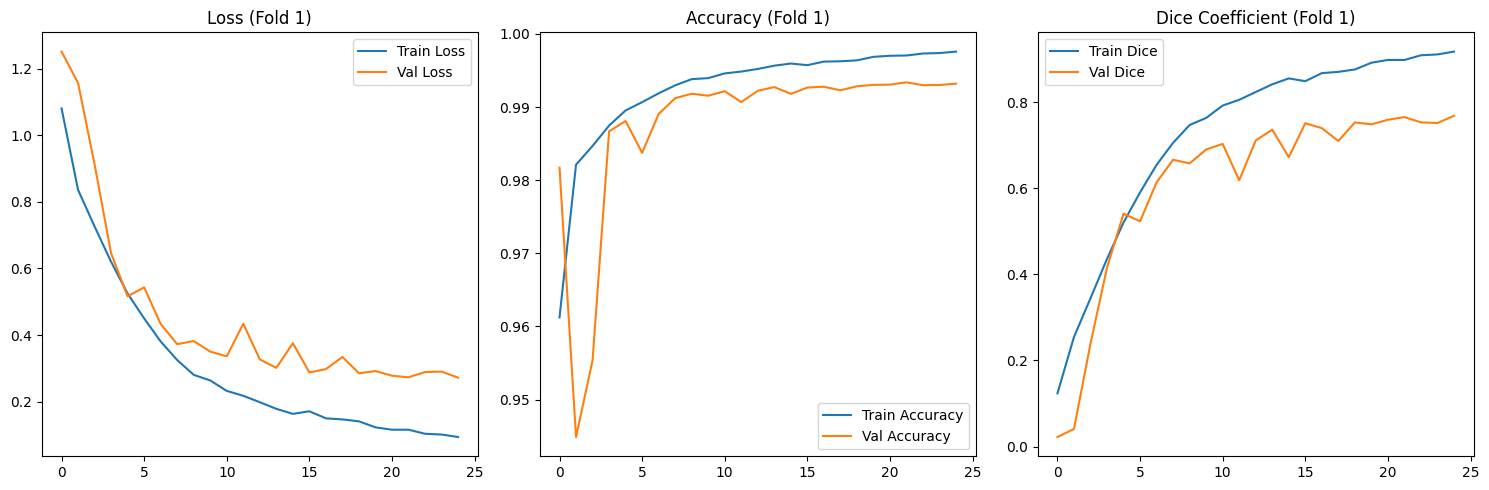


📊 === Fold 2 Summary ===
Final Train Accuracy: 0.9982
Final Val Accuracy:   0.9934
Final Train Dice:     0.9338
Final Val Dice:       0.7734


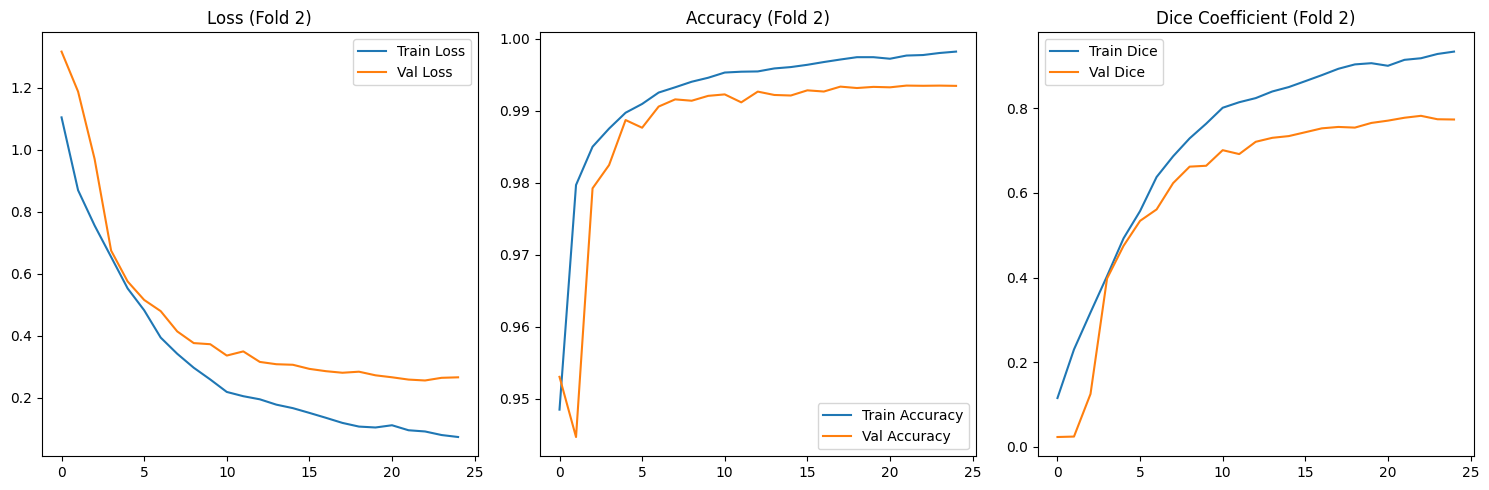

In [10]:
# VISUALIZE TRAINING RESULTS (SAME AS BEFORE)
for fold, history in enumerate(histories, 1):
    print(f"\n📊 === Fold {fold} Summary ===")
    print(f"Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Val Accuracy:   {history.history['val_accuracy'][-1]:.4f}")
    print(f"Final Train Dice:     {history.history['dice_coef'][-1]:.4f}")
    print(f"Final Val Dice:       {history.history['val_dice_coef'][-1]:.4f}")

    # Plot training history
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title(f"Loss (Fold {fold})")

    plt.subplot(1, 3, 2)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.legend()
    plt.title(f"Accuracy (Fold {fold})")

    plt.subplot(1, 3, 3)
    plt.plot(history.history["dice_coef"], label="Train Dice")
    plt.plot(history.history["val_dice_coef"], label="Val Dice")
    plt.legend()
    plt.title(f"Dice Coefficient (Fold {fold})")

    plt.tight_layout()
    plt.show()

In [11]:
# TEST THE MODEL (SAME AS BEFORE)
print("🧪 Testing the model...")

# Load the best model from last fold
best_model = tf.keras.models.load_model(
    f"/content/unet_plus_plus_fold{FOLDS}.h5",
    custom_objects={
        "bce_dice_loss": bce_dice_loss,
        "dice_coef": dice_coef
    }
)

# Create test dataset
test_ds = create_dataset(test_images, test_masks, training=False)

# Evaluate on test set
test_results = best_model.evaluate(test_ds)
print("\n🎯 === Test Results ===")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Dice: {test_results[1]:.4f}")
print(f"Test Accuracy: {test_results[2]:.4f}")

🧪 Testing the model...


58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - accuracy: 0.9939 - dice_coef: 0.7754 - loss: 0.2598

🎯 === Test Results ===
Test Loss: 0.2558
Test Dice: 0.7796
Test Accuracy: 0.9942


👁️ Visualizing predictions with tumor highlighting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


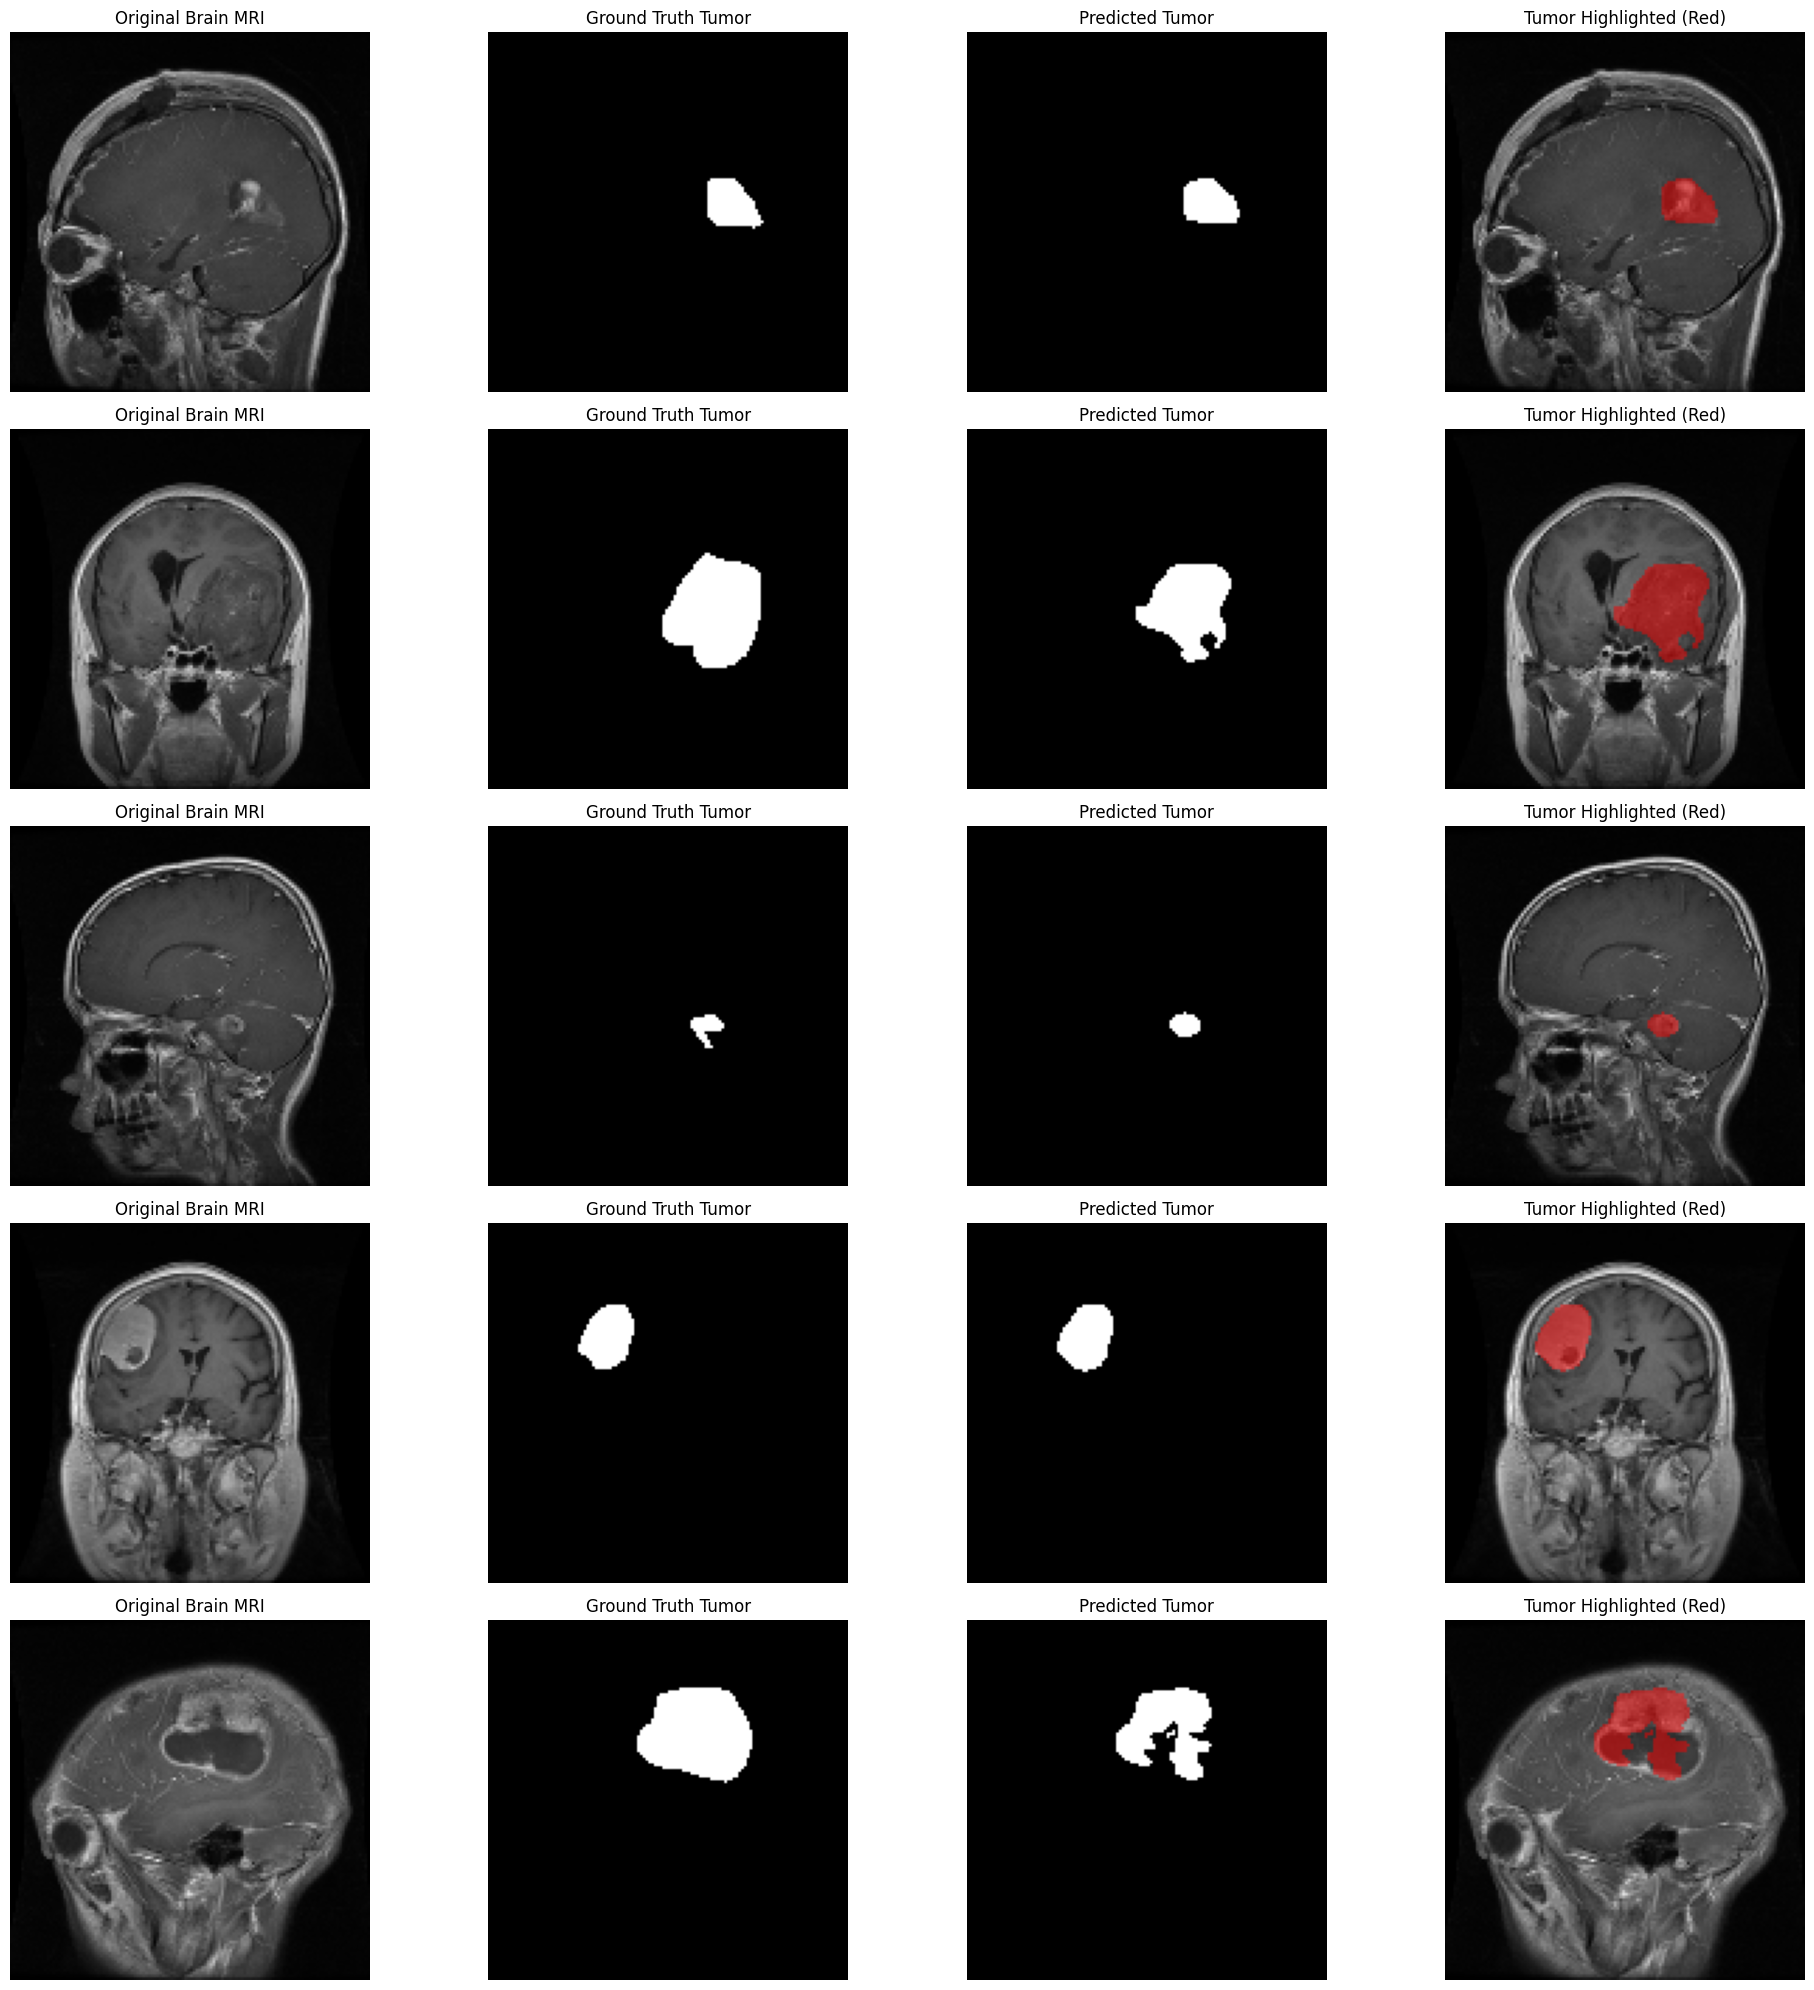

In [12]:
# VISUALIZE PREDICTIONS WITH TUMOR HIGHLIGHTING (SAME AS BEFORE)
def visualize_predictions_with_highlight(model, test_images, test_masks, num_samples=5):
    """
    Visualize predictions with tumor regions highlighted
    """
    # Select random samples
    indices = random.sample(range(len(test_images)), num_samples)

    plt.figure(figsize=(20, num_samples * 4))

    for i, idx in enumerate(indices):
        # Load and preprocess image
        img_path = os.path.join(images_path, test_images[idx])
        mask_path = os.path.join(masks_path, test_masks[idx])

        img, true_mask = load_and_preprocess_image(img_path, mask_path)

        # Add batch dimension and predict
        pred_mask = model.predict(tf.expand_dims(img, 0))[0]
        pred_mask_binary = (pred_mask > 0.5).astype(np.float32)

        # Convert to numpy for visualization
        img_np = img.numpy()
        true_mask_np = true_mask.numpy().squeeze()
        pred_mask_np = pred_mask_binary.squeeze()

        # Create overlay (red highlight for tumor regions)
        overlay = img_np.copy()
        # Highlight predicted tumor regions in red
        overlay[pred_mask_np > 0.5] = [1.0, 0.0, 0.0]  # Red color

        # Blend original image with overlay
        alpha = 0.5
        highlighted = img_np * (1 - alpha) + overlay * alpha

        # Plot results
        # Original Image
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(img_np)
        plt.title("Original Brain MRI")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(true_mask_np, cmap='gray')
        plt.title("Ground Truth Tumor")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(pred_mask_np, cmap='gray')
        plt.title("Predicted Tumor")
        plt.axis('off')

        # Highlighted Tumor Regions
        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(highlighted)
        plt.title("Tumor Highlighted (Red)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions
print("👁️ Visualizing predictions with tumor highlighting...")
visualize_predictions_with_highlight(best_model, test_images, test_masks, num_samples=5)

📤 Upload your own brain MRI image for testing...


Saving Screenshot_20251003_025650.png to Screenshot_20251003_025650.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


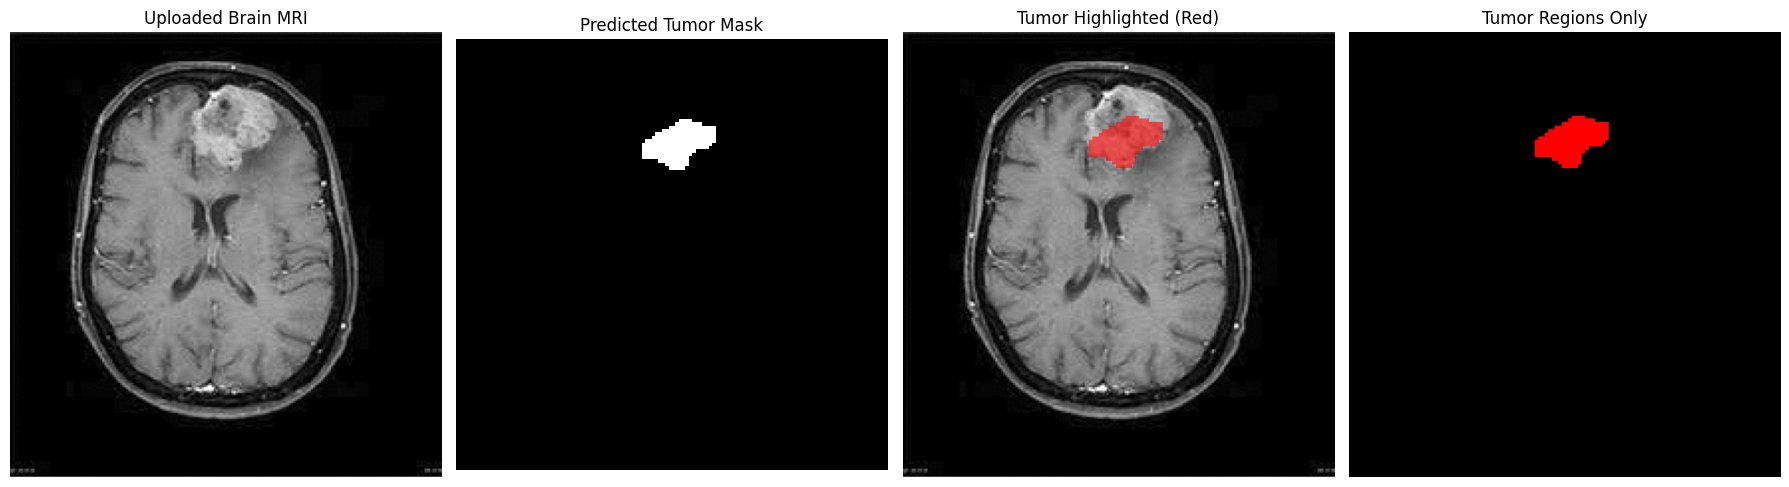


📊 Tumor Analysis:
Tumor Area: 2994 pixels
Total Image Area: 236626 pixels
Tumor Coverage: 1.27%
🚨 Tumor detected in the image!


In [13]:
# UPLOAD AND TEST CUSTOM IMAGE (EXACTLY THE SAME AS BEFORE)
print("📤 Upload your own brain MRI image for testing...")
from google.colab import files

uploaded = files.upload()

if uploaded:
    # Process uploaded image
    img_path = list(uploaded.keys())[0]

    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    original_size = img.size

    # Resize for model
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img_resized) / 255.0
    img_tensor = np.expand_dims(img_array, axis=0)

    # Predict
    pred_mask = best_model.predict(img_tensor)[0]
    pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)

    # Resize prediction back to original size
    pred_mask_original = Image.fromarray((pred_mask_binary.squeeze() * 255).astype(np.uint8))
    pred_mask_original = pred_mask_original.resize(original_size, Image.NEAREST)
    pred_mask_original = np.array(pred_mask_original) / 255.0

    # Create overlay
    original_img_array = np.array(img)
    overlay = original_img_array.copy().astype(float) / 255.0

    # Create red highlight for tumor regions
    highlight_mask = pred_mask_original > 0
    overlay[highlight_mask] = [1.0, 0.0, 0.0]  # Red color

    # Blend
    alpha = 0.6
    highlighted = (original_img_array / 255.0) * (1 - alpha) + overlay * alpha

    # Display results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title("Uploaded Brain MRI")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
    plt.title("Predicted Tumor Mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(highlighted)
    plt.title("Tumor Highlighted (Red)")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    # Show only the tumor regions in red on black background
    tumor_only = np.zeros_like(original_img_array)
    tumor_only[highlight_mask] = [255, 0, 0]  # Red tumors
    plt.imshow(tumor_only)
    plt.title("Tumor Regions Only")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate tumor statistics
    tumor_pixels = np.sum(highlight_mask)
    total_pixels = original_size[0] * original_size[1]
    tumor_percentage = (tumor_pixels / total_pixels) * 100

    print(f"\n📊 Tumor Analysis:")
    print(f"Tumor Area: {tumor_pixels} pixels")
    print(f"Total Image Area: {total_pixels} pixels")
    print(f"Tumor Coverage: {tumor_percentage:.2f}%")

    if tumor_pixels > 0:
        print("🚨 Tumor detected in the image!")
    else:
        print("✅ No tumor detected in the image.")